In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

def non_trivialize_df(df):
    # Search columns for trivial feature (virus)
    dropped = 0
    for idx, col in enumerate(df.columns):
        uniques = df[col].unique()
        num_unique = len(uniques)
        if num_unique == 1 and 'sera_table' not in col and "*" in uniques: # Critereon for a missing virus
#             print(idx, col, num_unique, uniques)
            df = df.drop(columns=col)
            dropped += 1 # Count dropped virus
    # Search rows for trivial entry (serum)
    for idx in list(df.index):
        num_unique = len(df.loc[idx].unique())
        if num_unique == 3: # Serum name and table name are 2 constant features.
#             print(idx, num_unique)
            df = df.drop(index=idx)
    df = df.replace("*", np.nan)
    df = df.set_index('Measurements (Sera in Rows/Viruses in Columns)')
    df = df.drop(['sera_table'], axis=1)
    df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
    # Return data and number of dropped viruses
    return df, dropped


def plot_heatmap(df):
    mask = df.isnull()
    g = sns.heatmap(df, cmap='gray',mask=mask)
    g.set_facecolor('xkcd:salmon')
    return g


def plot_heatmap_subplot(table_dict):
#     keys = sorted(list(table_dict.keys()))
    keys = ["TableS1", "TableS3", "TableS5", "TableS6", "TableS13", "TableS14"]
    N = len(keys)
    fig, axs = plt.subplots(nrows=1, ncols=N, figsize=(30, 5))
    for idx, key in enumerate(keys):
        df, dropped_viruses = table_dict[key]
        percent_missing = sum(list(df.isna().sum())) / (df.shape[0] * df.shape[1]) # Proportion of missing vals in table
        df = np.log10(df)
        sera_num = df.shape[0]
        virus_num = df.shape[1]
        mask = df.isnull()
        g = sns.heatmap(df,
                        xticklabels=False,
                        yticklabels=False,
                        cmap='gray',
                        mask=mask,
                        ax=axs[idx])
        g.set_facecolor('xkcd:salmon')
        axs[idx].set_xlabel(f'{sera_num} Sera x {virus_num} Viruses\n{percent_missing * 100:.2f}% Missing')
        axs[idx].set_title(key)
    return fig, axs

In [2]:
def train_tree(target_table: "pd.DataFrame",
               source_tables: "list(pd.DataFrame)",
               feature_t: "str",
               selected_viruses_list: "bool OR list(str)" = False,
               n_feature = 5,
               f_sample=0.3,
               k=1):
    '''
    Function performs:
    - Data cleaning to ensure that viruses have sufficient sera data
    - Selection of virus features which are found in training dataset
    - Virus Selection: selected_viruses_list can be either False for random virus selection or a list of viruses

    Output:
    - For a single target virus, output a list containing:
        - dtr
        - RMSE
        - cross_RMSE
        - virus_col_sel
        - feature_t
        
    Assumptions:
    - This function should be interchangeable with an ensemble tree trainer
    - Target virus which the tree has been trained on is found in training data
        - Cannot train a tree to predict a virus otherwise!
    - Each source table is used for training a tree and finding its
      associated cross-validation RMSE. Table which you want to make
      predictions on is also required so that trees can be trained 
      with relevant viruses.
    - target_table should be a dataframe where columns are viruses
      and row indices are seras. The value for each virus-serum pair
      is an HAI score for binding.
    - tables source_tables are analagous to target_table in structure
    - When talking about cross-validation RMSE,
      I train a tree on data (5 selected viruses X subset of sera) and make predictions
      on testing/validating data (5 selected viruses X all viable sera that weren't used for training).
      I believe that I am cross validating on Sera as selected viruses remain constant
      accuracy of a tree trained on
    '''
#     np.random.seed(42) # Random seed selection # Ummm, setting random seed will make all trees of a target train on the same viruses (really bad lol)
    skipped_viruses = [] # For viruses which have absolutely no sera data in training dataset, skip
    tree_dict = dict() # Will contain trained tree, cross-validation RMSE, and (truth, predictions) for cross validation 
    for idx, train_table in enumerate(source_tables):
        # Feature selection step
        data_t = target_table # Data that we want to make prediction on 
        data_assist_train = train_table #np.log10(train_table) # Main dataframe used in training and validation (Perform log10 transform)
        # Choose viruses that are covered by 80% of sera 
        if (data_assist_train.apply(lambda x: x.count(), axis=0) / data_assist_train.shape[0] > 0.8).sum() > n_feature:
            # f_col_ind_train should be a list of viruses covered by >80% of sera
            f_col_ind_train = list(data_assist_train.columns[(data_assist_train.apply(lambda x: x.count(), axis=0) / data_assist_train.shape[0] > 0.8).tolist()]) # Only consider viruses that are covered by > 80% of sera in study
            if feature_t in f_col_ind_train:
                f_col_ind_train.remove(feature_t)
        else:
            print(f"n_feature too large for assisting data {k}! Skipped to next data.")
        f_tmp_ind = [data_t.columns.get_loc(col) for col in f_col_ind_train if col in data_t.columns] # Find indices of columns that intersect f_col_ind_train and data_t
        f_feasible = [col for col in data_t.columns[f_tmp_ind] if data_t[col].count() > 2] # Choose viruses that have more than 2 sera values in prediction data
        f_col_ind_train = [col for col in f_col_ind_train if col in f_feasible] # Intersects cols from f_feasible and f_col_ind_train
        if len(f_feasible) < 2:
            print(f"n_feature too large for assisting data {k}! Skipped to next data.")
        data_assist_train = data_assist_train.dropna(subset=[feature_t]) # Drops NAs in training data for target
    
        # Perform checks on validity of training data
        '''
        Training conditions:
        (1) Training dataset must have sera binding data on target virus
        (2) Target feature is in training data (only way target dataset error (cross_RMSE) can be computed)
        '''
        if data_assist_train.shape[0] == 0: # (1)
            return
        if feature_t in data_t:
            if sum(np.isnan(data_t[feature_t])) == len(data_t[feature_t]): # (2)
    #                print(f"sum(np.isnan(data_t[feature_t])): {sum(np.isnan(data_t[feature_t]))}")
                return
        else:
    #         print(f"{feature_t} not in data_t")
            return
        # Training step (and single cross validation):
        if selected_viruses_list: # If selected_viruses_list is not False, I'm assuming its just a list of virus names
            virus_col_sel = np.array(selected_viruses_list) # Viruses we specifically want to train on and use for predictions in predicting data
        else:
            features_list = list(data_assist_train.columns) # Make sure feature_t isn't in features to train on
            features_list.remove(feature_t)
            virus_col_sel = np.random.choice(f_feasible, n_feature, replace=True)

        sera_row_sel = np.random.choice(data_assist_train.shape[0], int(data_assist_train.shape[0] * f_sample), replace=True) # Randomly selected sera
        # We want to include the column of f_t_ind into our data_train
        data_train = data_assist_train.iloc[sera_row_sel][np.append(virus_col_sel, feature_t)] # Training data subset covering virus_col_sel viruses and sera_row_sel sera
        col_mean_t = data_train.apply(lambda x: x.mean(), axis=1) # Prepare to mean center the training data
        data_train = data_train - np.outer(np.ones(data_train.shape[1]), col_mean_t).T # Mean center the training data
        data_train.columns = np.append(virus_col_sel, "target")
        dtr = DecisionTreeRegressor(min_samples_split=5)
        dtr.fit(data_train.iloc[:, :-1], data_train["target"]) # Train on selected viruses and sera, evaluate with target virus
        # Compile validation dataset, really performing a single cross validation (evaluate on data complementary to training data)
        data_test = data_assist_train.drop([data_assist_train.index[idx] for idx in sera_row_sel], axis=0)[np.append(virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
        col_mean_t = data_test.apply(lambda x: x.mean(), axis=1)
        data_test = data_test - np.outer(np.ones(data_test.shape[1]), col_mean_t).T
        pred_t = dtr.predict(data_test.iloc[:, :-1]) # Make prediction on target using unforeseen data
        RMSE = np.sqrt(np.mean((pred_t - data_test[feature_t]) ** 2))

        # Compile testing dataset using data_t for cross-table RMSC
        cross_virus_col_sel = virus_col_sel # Viruses we specifically want to train on and use for predictions in predicting data
        cross_sera_row_sel = np.random.choice(data_t.shape[0], int(data_t.shape[0] * f_sample), replace=True) # Randomly selected sera        data_test = data_assist_train.drop([data_assist_train.index[idx] for idx in sera_row_sel], axis=0)[np.append(virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
        cross_data_test = data_t[np.append(cross_virus_col_sel, feature_t)] # Testing data subset covering virus_col_sel viruses and all sera not covered by training data 
        cross_col_mean_t = cross_data_test.apply(lambda x: x.mean(), axis=1)
        cross_data_test = cross_data_test - np.outer(np.ones(cross_data_test.shape[1]), cross_col_mean_t).T
        cross_pred_t = dtr.predict(cross_data_test.iloc[:, :-1]) # Make prediction on target using unforeseen data

        # OKOKOK, we can only find cross_RMSE if target table actually contains target feature...
        cross_RMSE = np.sqrt(np.mean((cross_pred_t - cross_data_test[feature_t]) ** 2)) 
        if np.isnan(cross_RMSE):
            '''
            Problems with cross_data_test[feature_t]
            - Select better viruses to train on! Likely reason for failure is that im not choosing trainable viruses
            '''
            print("Problem with computing cross_RMSE!!!")
            print(cross_virus_col_sel)
            print(cross_data_test)
            print("PREDICTIONS:")
            print(cross_pred_t)
            print()
    return [dtr, RMSE, cross_RMSE, virus_col_sel, feature_t]
    

In [3]:
def m_best_trees_trainer(target_table: "pd.DataFrame",
                         source_tables: "list(pd.DataFrame)",
                         feature_t: "str",
                         selected_viruses_list: "bool OR list(str)" = False,
                         n_feature = 5,
                         f_sample=0.3,
                         train_trees=10,
                         best_trees=5,
                         k=1):
    '''
    This function will call the subroutine N number of times to generate N trees, from which the M best may be selected/returned
    Might also want to store a list of the target + training viruses for each tree made (might be like a bar code or signature)
    Once a bunch of trees are returned for the comparison between the target and training datasets (including a map from "tree name" : "list of involved viruses")
    we may compute an error line for each training virus in the comparison plot. With this Error line, we have our means of computing the worst case error of a 
    prediction.
    '''
    train_tree_list_list = [] # A single train_tree_list_list corresponds to the current target virus
    for i in range(train_trees): # Make some trees
        train_tree_list = train_tree(target_table = target_table,
                                     source_tables = source_tables,
                                     feature_t = feature_t,
                                     selected_viruses_list = selected_viruses_list,
                                     n_feature = n_feature,
                                     f_sample = f_sample,
                                     k = k)
        if train_tree_list is None:
#             print("NONE???")
            return train_tree_list
        dtr, RMSE, cross_RMSE, virus_col_sel, feature_t = train_tree_list
        train_tree_list_list.append(train_tree_list)
    # Rank trees in descending order by cross validation RMSE (not cross table RMSE which iis cross_RMSE)
    train_tree_list_list = sorted(train_tree_list_list, key = lambda x:x[1]) 
    return train_tree_list_list[:best_trees]
    

In [4]:
'''
data_t: DF of sera (table specific) X Viruses (No viruses dropped yet) to make prediction on
data_s_list: list of columns of data table for virus to train on ... Its the whole df I think
feature_t: A particular virus to predict (And I assume we omit this from training)
n_tree=50
n_feature=5
f_sample=0.3
n_best_tree=5
'''

flu_df = pd.read_csv("../CrossStudyCompletion/Matrix Completion in R/InfluenzaData.csv", sep=',')
sera = flu_df['Measurements (Sera in Rows/Viruses in Columns)'].tolist()
sera_tables = [i[i.index('Table'):] for i in sera]
table_keys = set(sera_tables)
flu_df['sera_table'] = sera_tables

flu_table_dict = {table_key: flu_df.loc[flu_df['sera_table']==table_key] for table_key in table_keys}
filtered_flu_table_dict = {key: non_trivialize_df(arg) for key, arg in list(flu_table_dict.items())}

predict_table = 'TableS14'
train_table = 'TableS13'
data_df = flu_df.set_index("Measurements (Sera in Rows/Viruses in Columns)")
data_df = data_df.applymap(lambda x: pd.to_numeric(x, errors='coerce') )
data_df = np.log10(data_df)
data_df['sera_table'] = sera_tables

data_t = data_df.loc[data_df['sera_table']==predict_table].drop(['sera_table'], axis=1)
data_s = data_df.loc[data_df['sera_table']==train_table].drop(['sera_table'], axis=1)
data_s_list = [data_s] # [[col] for col in list(data_s.columns)]
feature_t = "A/PANAMA/2007/99"

/tmp/ipykernel_471/2183625197.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/tmp/ipykernel_471/2183625197.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/tmp/ipykernel_471/2183625197.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/tmp/ipykernel_471/2183625197.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce') ) # Might wanna just do df.map
/tmp/ipykernel_471/2183625197.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 

# Creating Figure S1

### Notes:
- Somethings up with "HN196/2009" ?
    - Apparently its only found in tables S1 and S3
    - Could we do a weird network thing where we impute values for the rest of the tables (S5, S5, S13, S14) by
      finding which tables are most immediately transferable with each other? Might be cool way of forming a DAG
      to satisfy missing values between tables (or naive lol)
      
- Issue with computing Cross RMSEs for some viruses
    - Could be insufficient sera which are feasible for training?

In [5]:
tableS1  = data_df.loc[data_df['sera_table']=="TableS1"].drop(['sera_table'], axis=1)
tableS3  = data_df.loc[data_df['sera_table']=="TableS3"].drop(['sera_table'], axis=1)
tableS5  = data_df.loc[data_df['sera_table']=="TableS5"].drop(['sera_table'], axis=1)
tableS6  = data_df.loc[data_df['sera_table']=="TableS6"].drop(['sera_table'], axis=1)
tableS13 = data_df.loc[data_df['sera_table']=="TableS13"].drop(['sera_table'], axis=1)
tableS14 = data_df.loc[data_df['sera_table']=="TableS14"].drop(['sera_table'], axis=1)
# table_names = ["tableS1" , "tableS3" , "tableS5" , "tableS6" , "tableS13", "tableS14"]
# table_list = [tableS1 , tableS3 , tableS5 , tableS6 , tableS13, tableS14]
table_names = ["tableS5" , "tableS6" , "tableS13" , "tableS14" , "tableS3", "tableS1"]
table_list = [tableS5 , tableS6 , tableS13 , tableS14 , tableS3, tableS1]

comparison_dict = dict()
for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            tree_dict = dict() # Contains {trees and RMSE data} collected from training a tree on target features of target_table
            # Preparing tree parameters
            feature_targets = list(target_table.columns) # List of viruses to make a tree/prediction on
            for i, feature_target in enumerate(feature_targets): # Make a tree for each virus in target_table if virus in source_table
                if feature_target in source_table.columns:
                    train_tree_list = train_tree(
                                                target_table=target_table,
                                                source_tables=[source_table], # Feed in a list containing our single source table (functionality on multiple source tables is intended (WIP))
                                                selected_viruses_list=False, # Set selected_viruses_list to false to randomly select viruses to train on
                                                feature_t=feature_target,
                                                )
                else:
                    print(f"{table_names[idx]} does not contain {feature_target} which {table_names[jdx]} seeks!")
                if train_tree_list is not None and len(train_tree_list) != 0:
                    tree_dict[feature_target] = train_tree_list
            comparison_dict[comparison_name] = tree_dict
#             print("----------------")
            print(f"Comparison from {source_table_name} to {target_table_name} completed")


Comparison from tableS5 to tableS6 completed
Comparison from tableS5 to tableS13 completed
Comparison from tableS5 to tableS14 completed
Comparison from tableS5 to tableS3 completed
Comparison from tableS5 to tableS1 completed
Comparison from tableS6 to tableS5 completed
Comparison from tableS6 to tableS13 completed
Comparison from tableS6 to tableS14 completed
Comparison from tableS6 to tableS3 completed
Comparison from tableS6 to tableS1 completed
Comparison from tableS13 to tableS5 completed
Comparison from tableS13 to tableS6 completed
Comparison from tableS13 to tableS14 completed
Comparison from tableS13 to tableS3 completed
Comparison from tableS13 to tableS1 completed
Comparison from tableS14 to tableS5 completed
Comparison from tableS14 to tableS6 completed
Comparison from tableS14 to tableS13 completed
Comparison from tableS14 to tableS3 completed
Comparison from tableS14 to tableS1 completed
Comparison from tableS3 to tableS5 completed
Comparison from tableS3 to tableS6 comp

In [6]:
print("Number of comparisons: ", len(comparison_dict))
print("Number of trees in comparison: ", len(tree_dict))


Number of comparisons:  30
Number of trees in comparison:  50


In [7]:
comparison_dict
intra_RMSE_dict = dict()
cross_RMSE_dict = dict()
for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            intra_RMSE_data = []
            cross_RMSE_data = []
            for target in list(comparison_dict[comparison_name].keys()):
                tree_data = comparison_dict[comparison_name][target] # Assuming that only one source table was used in training tree
                intra_RMSE_data.append(tree_data[1])
                cross_RMSE_data.append(tree_data[2])
            intra_RMSE_dict[comparison_name] = intra_RMSE_data
            cross_RMSE_dict[comparison_name] = cross_RMSE_data

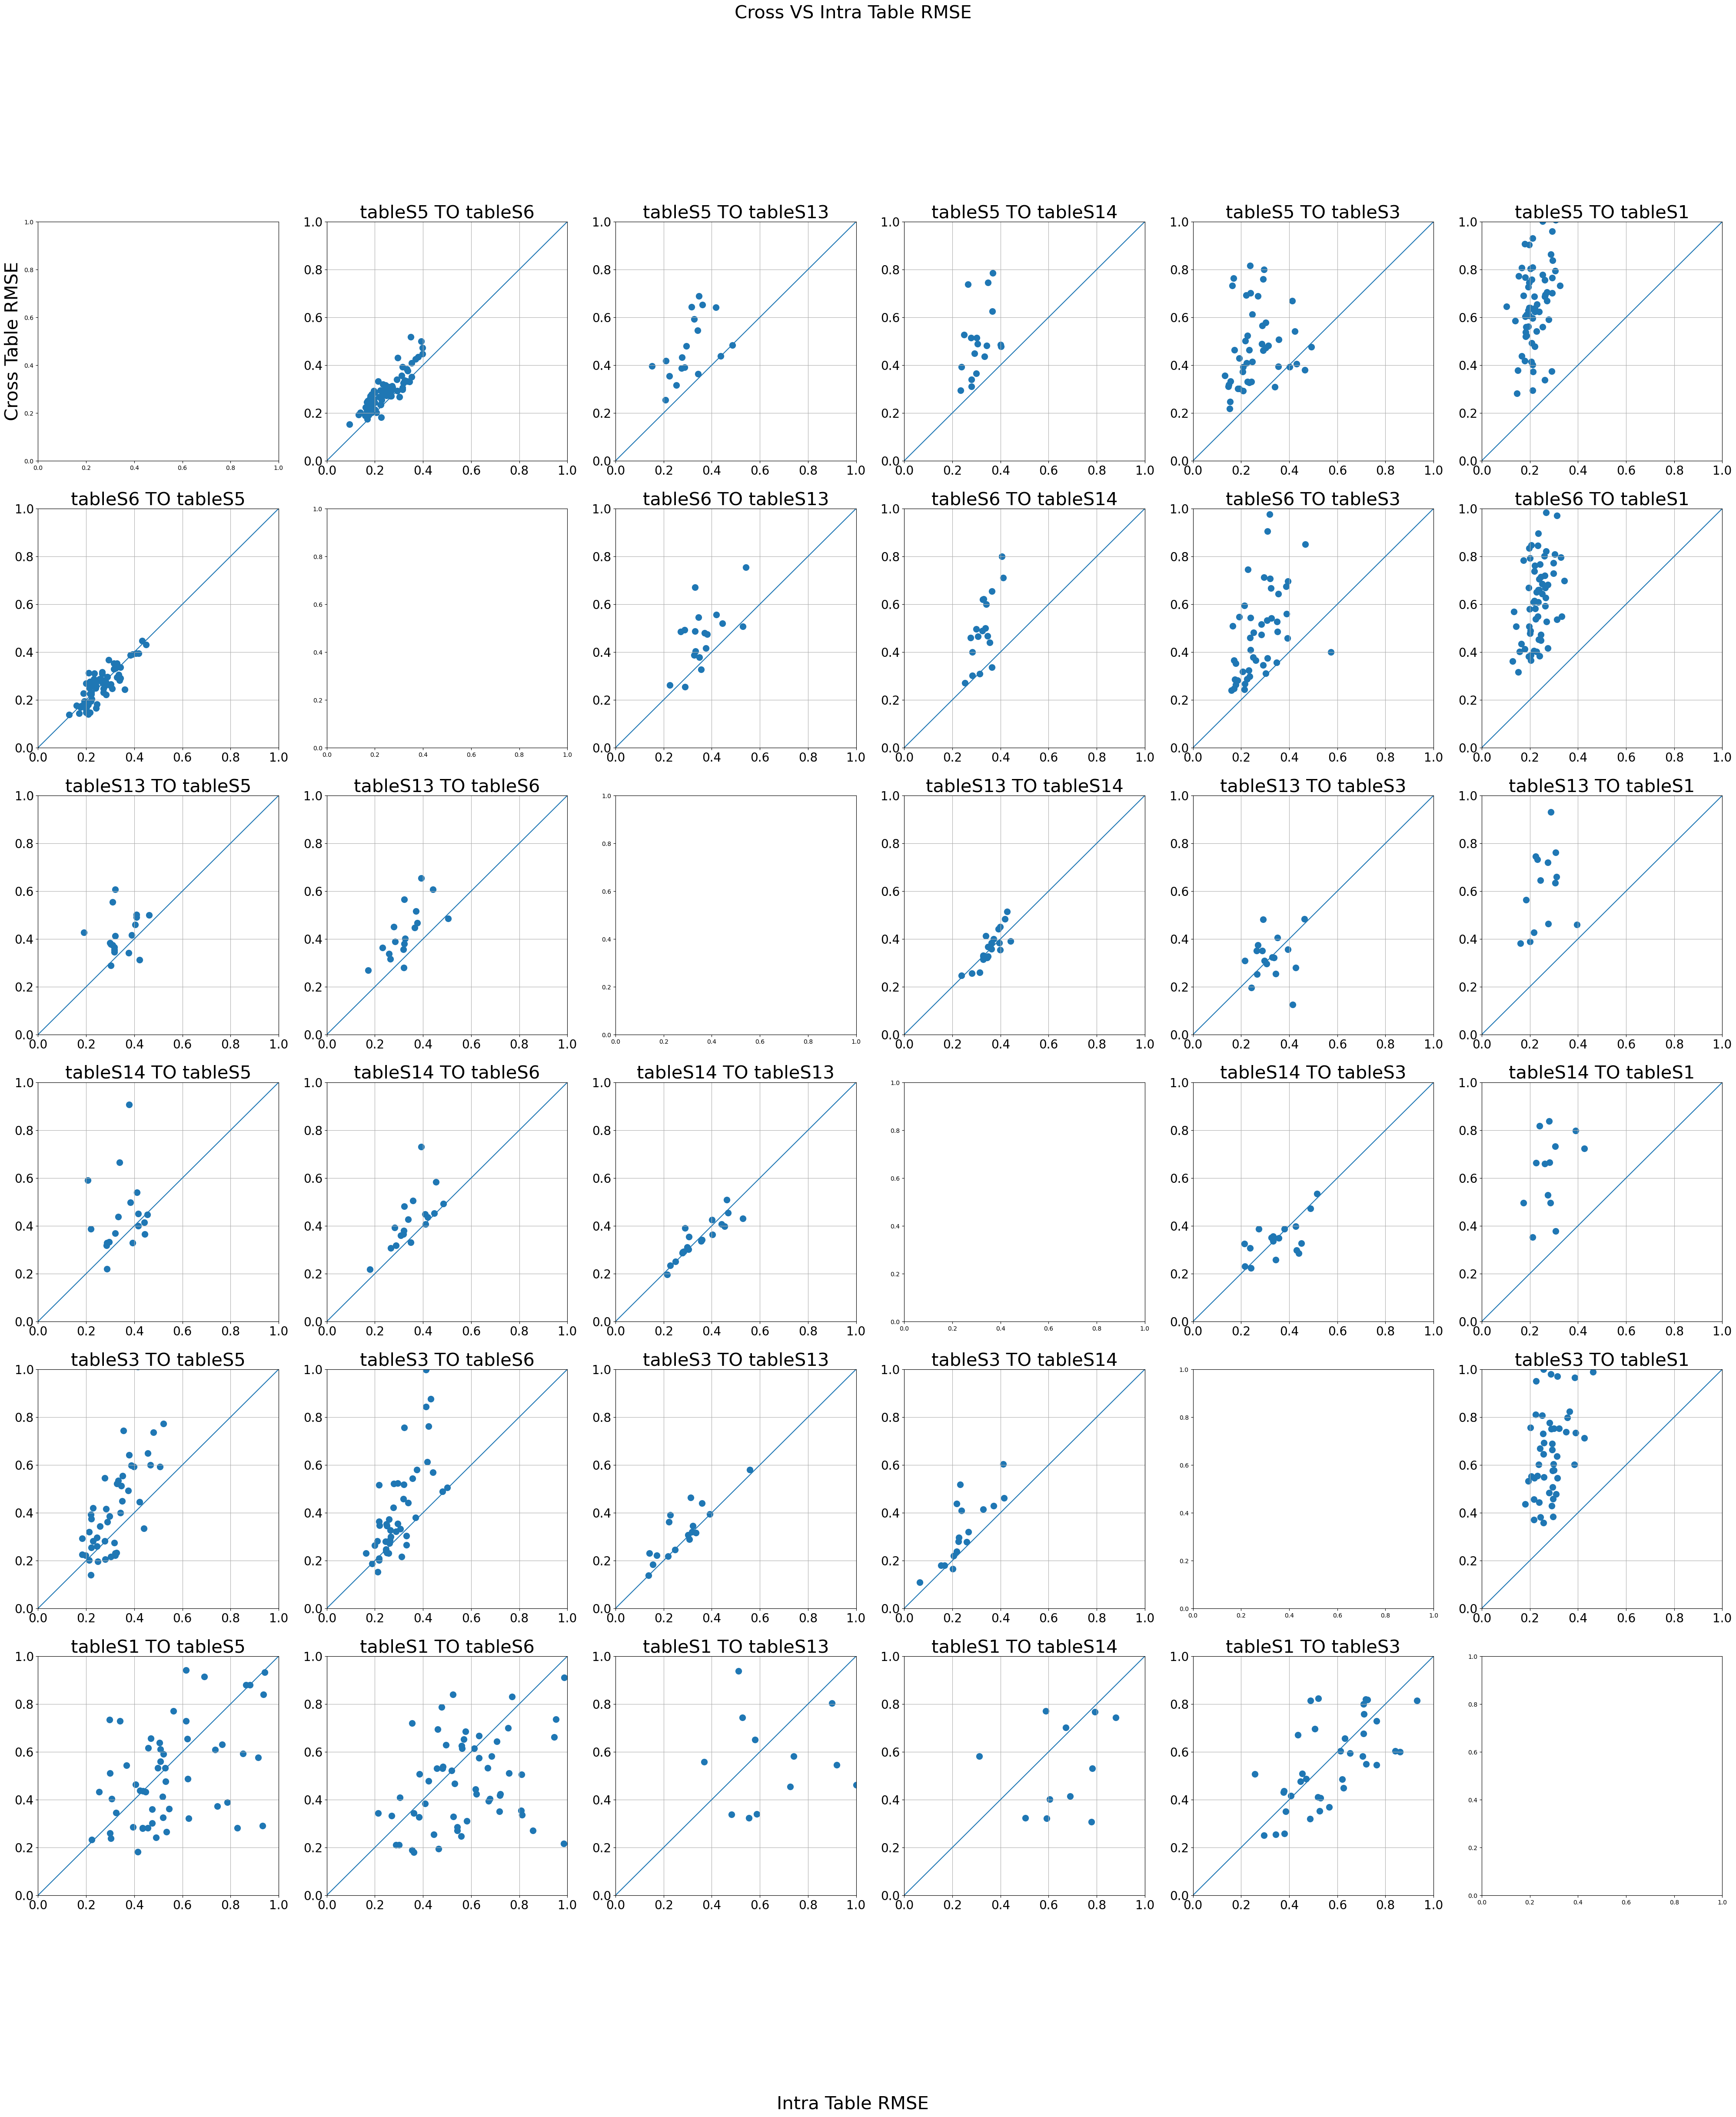

In [8]:
'''
Questions:
- When finding the cross RMSE:
    - Dataset is the whole target dataset, selected on 5 randomly selected feasible viruses
    - If the target virus has all NANs, my cross RMSE is NAN because of RMSE formula.
        - Should I only choose target viruses that have non-NAN values?
'''

nrows, ncols = len(table_names), len(table_names)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50, 50))

for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            
            x = intra_RMSE_dict[comparison_name]
            y = cross_RMSE_dict[comparison_name]

            axs[idx, jdx].scatter(x,y, s=100)
            axs[idx, jdx].set_title(comparison_name, fontsize = 30)
            axs[0,0].set_ylabel("Cross Table RMSE", fontsize = 30)
            axs[idx, jdx].tick_params(axis='both', which='major', labelsize=20)
            axs[idx, jdx].grid()
            axs[idx, jdx].plot([0, 1], [0, 1], transform=axs[idx, jdx].transAxes)
            axs[idx, jdx].set_xlim([0, 1])
            axs[idx, jdx].set_ylim([0, 1])
        fig.suptitle("Cross VS Intra Table RMSE", fontsize=30)
        fig.supxlabel('Intra Table RMSE', fontsize=30)

# TODO:
- Get function to train 10 trees and output the 5 best trees (Outputs N trees, chooses K best trees) for each virus in a dataset
    - Essentially, do everything that Figure 2 says
    - Incorporate thise into figure S1 to mimic Tal's original fig   
    - COOL VISUAL: Giant heatmap that shows all datasets overlapping with missing values in pink
        - After imputation of missing values, plot another heatmap
- Make a class or something to create a perpendicularly fit line on datapoints taken from Cross VS Intra RMSE comparisons of 2 samples
    - For each virus point, a new line should be fit on points that are not used for training the virus tree (Including the virus itself)
    - Perpendicular line fit should also be used past the point where x=y is 1 or something (look at the plot lol)
- Once each virus in table comparisons has a computed line, worst case errors for each virus based on their (1) specific tree and (2) Intra RMSE can be computed
- Bayesian averages of V_ij +- sigma_ij can then be coputed


In [9]:
tableS1  = data_df.loc[data_df['sera_table']=="TableS1"].drop(['sera_table'], axis=1)
tableS3  = data_df.loc[data_df['sera_table']=="TableS3"].drop(['sera_table'], axis=1)
tableS5  = data_df.loc[data_df['sera_table']=="TableS5"].drop(['sera_table'], axis=1)
tableS6  = data_df.loc[data_df['sera_table']=="TableS6"].drop(['sera_table'], axis=1)
tableS13 = data_df.loc[data_df['sera_table']=="TableS13"].drop(['sera_table'], axis=1)
tableS14 = data_df.loc[data_df['sera_table']=="TableS14"].drop(['sera_table'], axis=1)
# table_names = ["tableS1" , "tableS3" , "tableS5" , "tableS6" , "tableS13", "tableS14"]
# table_list = [tableS1 , tableS3 , tableS5 , tableS6 , tableS13, tableS14]
table_names = ["tableS5" , "tableS6" , "tableS13" , "tableS14" , "tableS3", "tableS1"]
table_list = [tableS5 , tableS6 , tableS13 , tableS14 , tableS3, tableS1]

comparison_dict = dict()
for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            tree_dict = dict() # Contains {trees and RMSE data} collected from training a tree on target features of target_table
            # Preparing tree parameters
            feature_targets = list(target_table.columns) # List of viruses to make a tree/prediction on
            for i, feature_target in enumerate(feature_targets): # Make a tree for each virus in target_table if virus in source_table
                if feature_target in source_table.columns:
                    train_tree_list = m_best_trees_trainer(target_table = target_table,
                                                           source_tables = [source_table],
                                                           feature_t = feature_target,
                                                           selected_viruses_list = False,
                                                           n_feature = 5,
                                                           f_sample=0.3,
                                                           train_trees=10,
                                                           best_trees=5,
                                                           k=1)
                else:
                    print(f"{table_names[idx]} does not contain {feature_target} which {table_names[jdx]} seeks!")
                if train_tree_list is not None and len(train_tree_list) != 0:
                    tree_dict[feature_target] = train_tree_list
            comparison_dict[comparison_name] = tree_dict
#             print("----------------")
            print(f"Comparison from {source_table_name} to {target_table_name} completed")


Comparison from tableS5 to tableS6 completed
Comparison from tableS5 to tableS13 completed
Comparison from tableS5 to tableS14 completed
Comparison from tableS5 to tableS3 completed
Comparison from tableS5 to tableS1 completed
Comparison from tableS6 to tableS5 completed
Comparison from tableS6 to tableS13 completed
Comparison from tableS6 to tableS14 completed
Comparison from tableS6 to tableS3 completed
Comparison from tableS6 to tableS1 completed
Comparison from tableS13 to tableS5 completed
Comparison from tableS13 to tableS6 completed
Comparison from tableS13 to tableS14 completed
Comparison from tableS13 to tableS3 completed
Comparison from tableS13 to tableS1 completed
Comparison from tableS14 to tableS5 completed
Comparison from tableS14 to tableS6 completed
Comparison from tableS14 to tableS13 completed
Comparison from tableS14 to tableS3 completed
Comparison from tableS14 to tableS1 completed
Comparison from tableS3 to tableS5 completed
Comparison from tableS3 to tableS6 comp

In [10]:

intra_RMSE_dict = dict()
cross_RMSE_dict = dict()
for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            intra_RMSE_data = []
            cross_RMSE_data = []
            for target in list(comparison_dict[comparison_name].keys()):
                tree_data = comparison_dict[comparison_name][target] # Assuming that only one source table was used in training tree
                for l in tree_data:
                    intra_RMSE_data.append(l[1])
                    cross_RMSE_data.append(l[2])
            intra_RMSE_dict[comparison_name] = intra_RMSE_data
            cross_RMSE_dict[comparison_name] = cross_RMSE_data

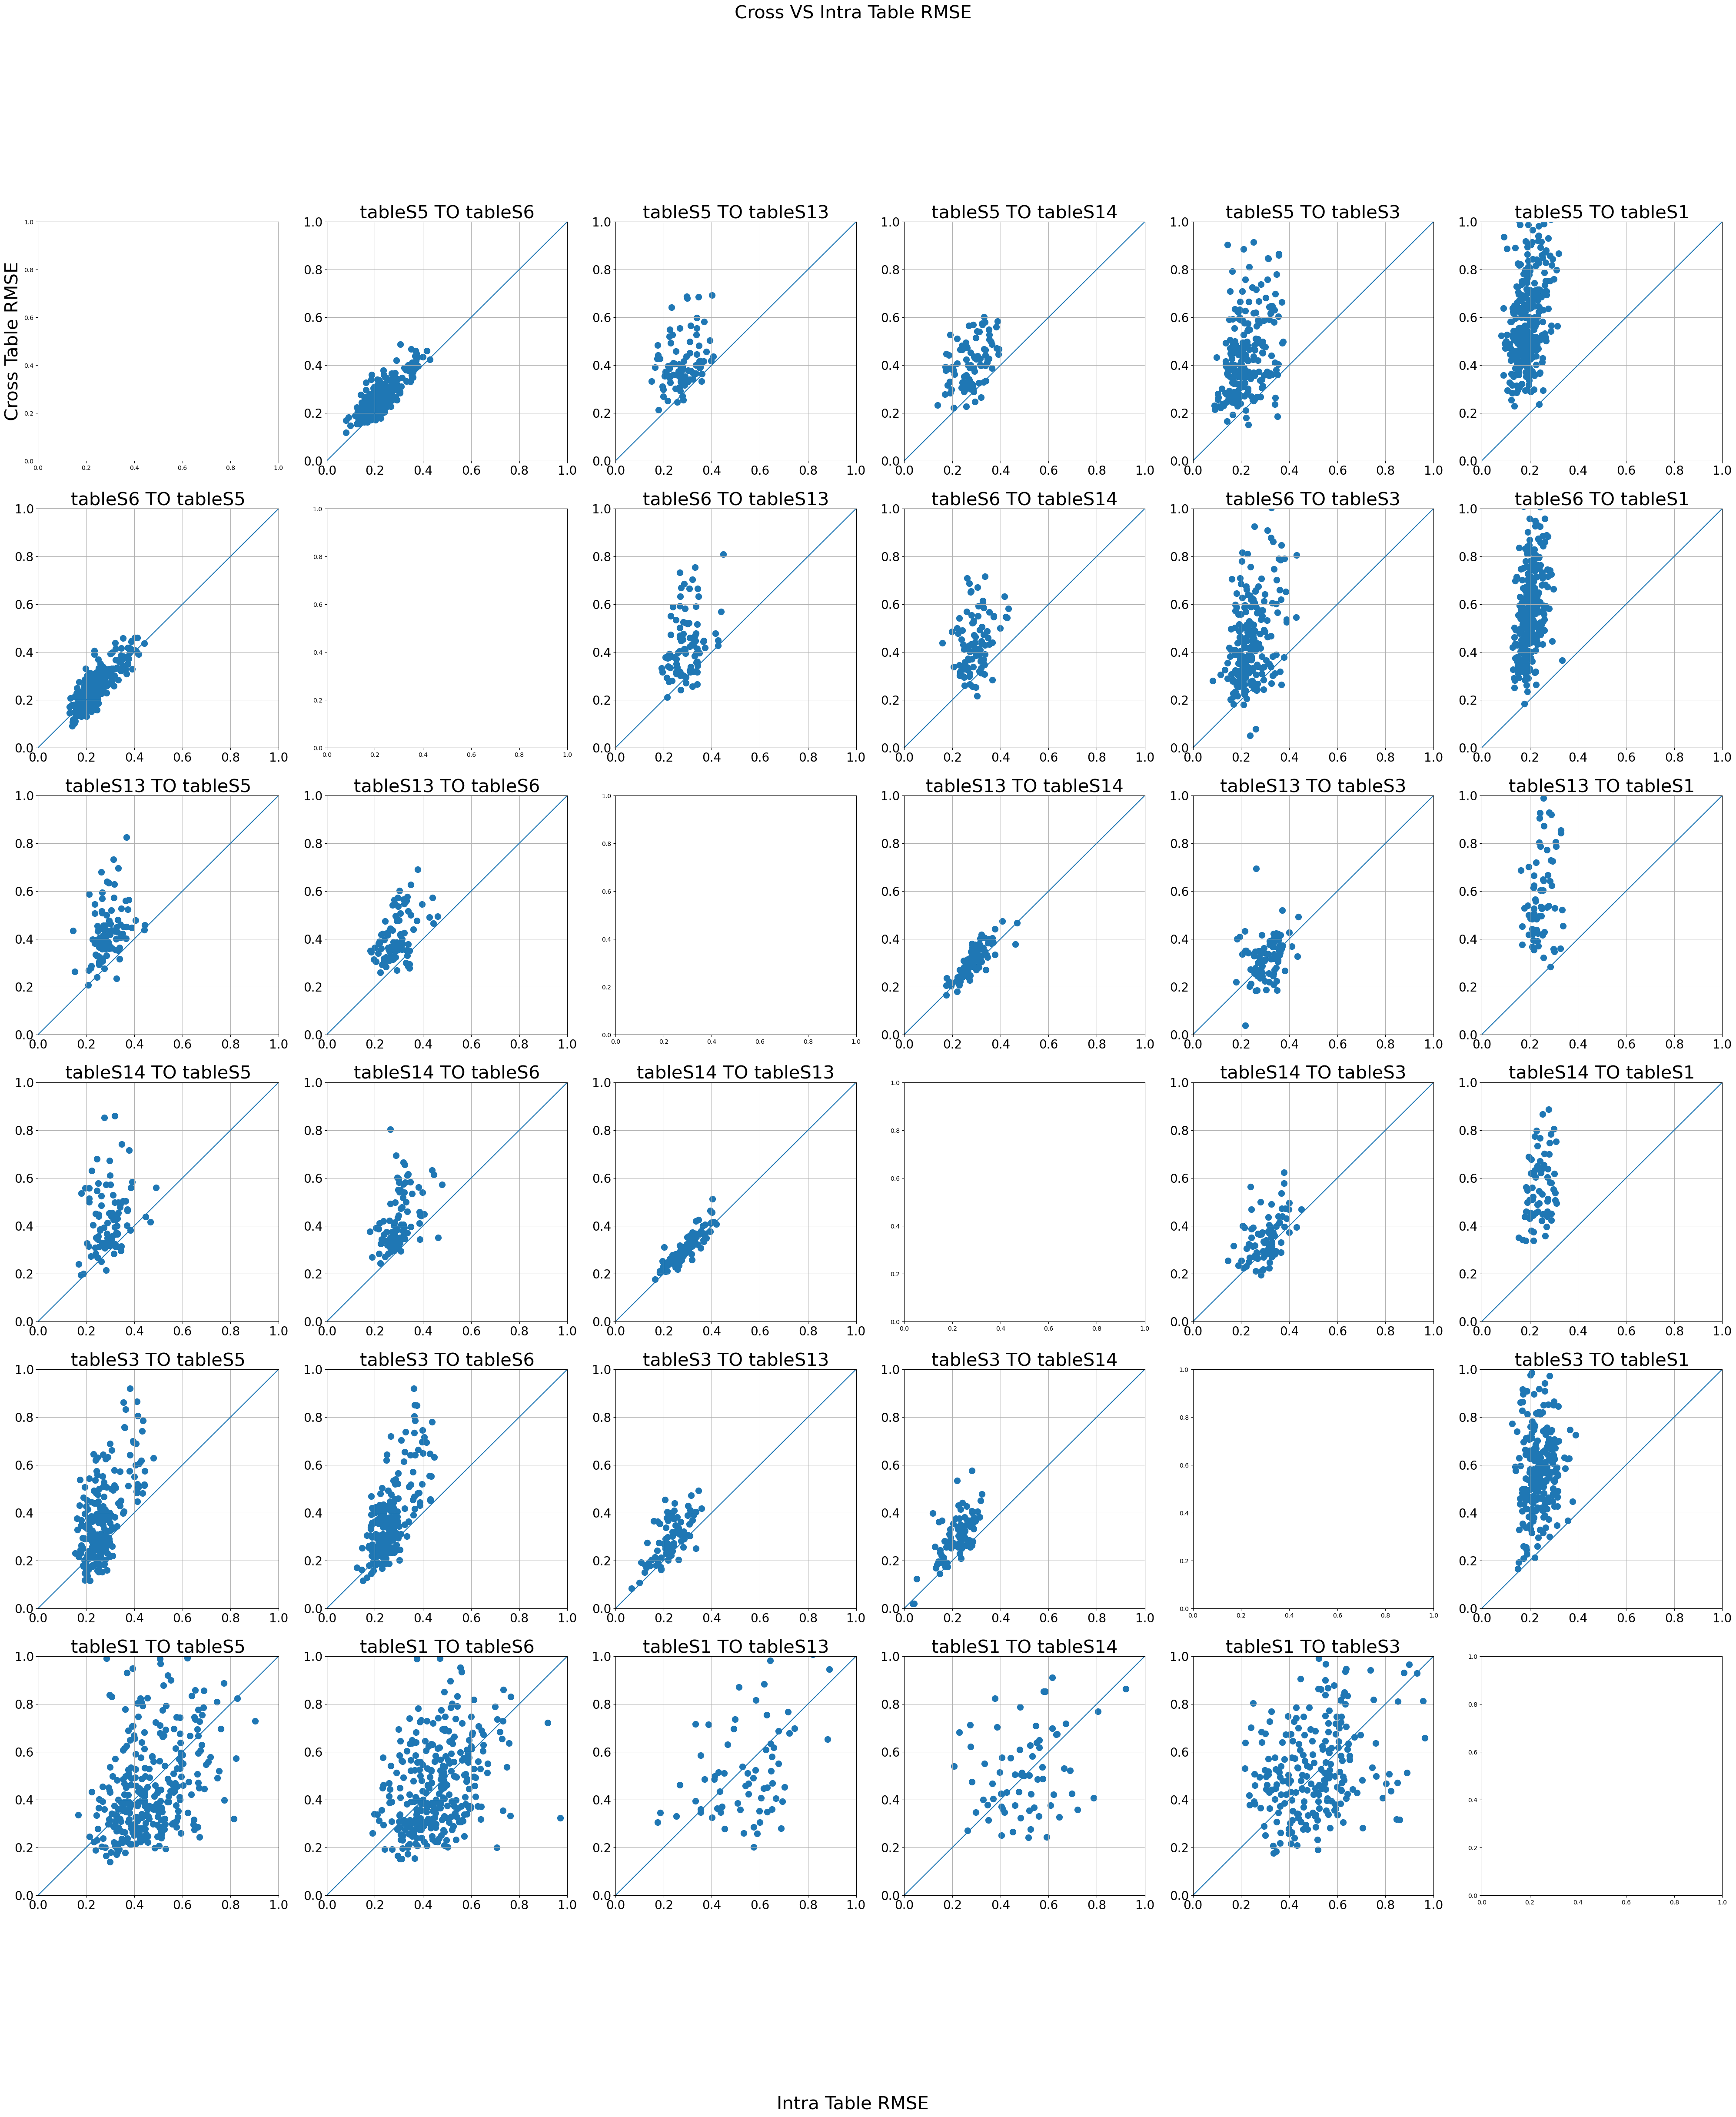

In [11]:
'''
Questions:
- When finding the cross RMSE:
    - Dataset is the whole target dataset, selected on 5 randomly selected feasible viruses
    - If the target virus has all NANs, my cross RMSE is NAN because of RMSE formula.
        - Should I only choose target viruses that have non-NAN values?
'''

nrows, ncols = len(table_names), len(table_names)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50, 50))

for idx, source_table in enumerate(table_list):
    source_table_name = table_names[idx]
    for jdx, target_table in enumerate(table_list):
        if idx != jdx: # Ensure that target table is not the same as source table
            # Dict names
            target_table_name = table_names[jdx]
            comparison_name = f"{source_table_name} TO {target_table_name}"
            
            x = intra_RMSE_dict[comparison_name]
            y = cross_RMSE_dict[comparison_name]

            axs[idx, jdx].scatter(x,y, s=100)
            axs[idx, jdx].set_title(comparison_name, fontsize = 30)
            axs[0,0].set_ylabel("Cross Table RMSE", fontsize = 30)
            axs[idx, jdx].tick_params(axis='both', which='major', labelsize=20)
            axs[idx, jdx].grid()
            axs[idx, jdx].plot([0, 1], [0, 1], transform=axs[idx, jdx].transAxes)
            axs[idx, jdx].set_xlim([0, 1])
            axs[idx, jdx].set_ylim([0, 1])
        fig.suptitle("Cross VS Intra Table RMSE", fontsize=30)
        fig.supxlabel('Intra Table RMSE', fontsize=30)